In [1]:
import jax.numpy as jnp
import jax
from jax.experimental.host_callback import id_print
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as random
from functools import partial
rng = random.PRNGKey(123)

import scipy

import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

# Generating Samples from $\mu_\text{data}$
The first thing we will do is generate samples from some target manifolds. 

They will generate $J$ sample points of a $M$-dimensional manifold in an ambient space of dimension $N$. 

The manifolds will be normalized straight away (centered and setting the variance to 1), so that we do not have to worry about normalizing our training data later.

In [65]:
def sample_sphere(J, M, N):
    """
    J: How many samples to generate
    M: Dimension of the submanifold
    N: Dimension of the embedding space
    Returns a (J, N) array of samples
    """
    assert M <= N-1
    #Implement for other dimensions than two
    dist = scipy.stats.qmc.MultivariateNormalQMC(mean=jnp.zeros(M+1))
    manifold = jnp.array(dist.random(J))
    norms = jnp.sqrt(jnp.sum(manifold**2, axis=1).reshape((J, 1)))
    manifold = manifold/norms
    norms = jnp.sum(manifold**2, axis=1).reshape((J, 1))
    if M+1 < N:
        manifold = jnp.concatenate([manifold, jnp.zeros((J, N-(M+1)))], axis=1)
    #normalization
    manifold = manifold - jnp.mean(manifold, axis=0)
    manifold = manifold / jnp.max(jnp.var(manifold, axis=0))
    return manifold
    
def sample_hyperplane(J, M, N):
    """
    J: How many samples to generate
    M: Dimension of the submanifold
    N: Dimension of the embedding space
    Returns a (J, N) array of samples
    """
    assert M <= N
    dist = scipy.stats.qmc.MultivariateNormalQMC(mean=jnp.zeros(M))
    manifold = jnp.array(dist.random(J))
    if M < N:
        manifold = jnp.concatenate([manifold, jnp.zeros((J, N-(M)))], axis=1)
    manifold = manifold - jnp.mean(manifold, axis=0)
    manifold = manifold / jnp.max(jnp.var(manifold, axis=0))
    return manifold

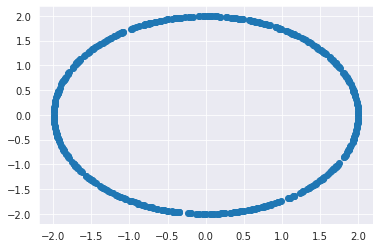

In [74]:
J = 500
D = 1
N = 2
mf = sample_sphere(J, D, N)
plt.scatter(mf[:, 0], mf[:, 1])

# The forward SDE
## Ornstein-Uhlenbeck process (OU process)
Let $O_t$ be an OU-Process with stationary distribution $\mathcal{N}(0, I)$, i.e. a solution to
$$\mathrm{d}O_t = -\frac{1}{2} O_t + \mathrm{d}B_t.$$
The $-\frac{1}{2}O_t$ is called the __drift__, and whatever is in front of the $\mathrm{d}B_t$ is called the __dispersion__ coefficient, in this case $1$. 

Its transition kernel is given by a normal distribution
$$p^O(x_t | x_0) = \mathcal{N}\left(\exp(-\frac{1}{2}t) x_0, (1 - \exp(-t))I\right)$$.

## Time-changed OU process
For numerical reasons it is often useful to change the time, i.e. instead treat
$$dX_t = -\frac{1}{2}\beta_t X_t + \sqrt{\beta_t} dB_t.$$
We define $\alpha_t = \int_0^t \beta_s \mathrm{d}s$. Then the __transition kernel__ of $X_t$ is given as 
$$p(x_t | x_0) = \mathcal{N}(m_t x_0, v_t I),$$ 
where

| | |
|---|---|
| $m_t$  | $\exp(-\frac{1}{2}\alpha_t)$ |
| $v_t$  | $1 - \exp(-\alpha_t)$ |.

We directly will implement the OU-SDE with the time-change parameters $\alpha_t$ and $\beta_t$ since they greatly impact the performance.

In particular we will use the function
$$\beta_t = \beta_\text{min} + t(\beta_\text{max} - \beta_\text{min}).$$
In this case we get
$$\alpha_t = t \beta_\text{min} + \frac{1}{2} t^2 (\beta_\text{max} - \beta_\text{min}).$$
This choice of $\beta_t$ is popular in practice.

You can later play around with different choices of $\beta_t$ and $\alpha_t$ or use the above proposals and play around with $\beta_\text{min}$ and $\beta_\text{max}$. An interesting paper in that regard is [1]. Good default values for $\beta_\text{min}$ and $\beta_\text{max}$ are
$$\beta_\text{min} = 0.001, \beta_\text{max} - 3.$$
You can implement the functions using these values for now

[1] Elucidating the Design Space of Diffusion-Based Generative Models, Tero Karras, Miika Aittala, Timo Aila, Samuli Laine. https://arxiv.org/abs/2206.00364

In [1]:
beta_min = 0.001
beta_max = 3

def beta_t(t):
    """
    t: time (number)
    returns beta_t as explained above
    """
    raise NotImplementedError
    
def alpha_t(t):
    """
    t: time (number)
    returns alpha_t as explained above
    """
    raise NotImplementedError

def drift(x, t):
    """
    x: location of J particles in N dimensions, shape (J, N)
    t: time (number)
    returns the drift of a time-changed OU-process for each batch member, shape (J, N)
    """
    raise NotImplementedError

def dispersion(t):
    """
    t: time (number)
    returns the dispersion
    """
    raise NotImplementedError

def mean_factor(t):
    """
    t: time (number)
    returns m_t as above
    """
    raise NotImplementedError

def var(t):
    """
    t: time (number)
    returns v_t as above
    """
    raise NotImplementedError

## Marginals of the time-changed OU-process
We have seen above that the time-$t$ transition kernel is given as
$$p(x_t | x_0) = \mathcal{N}(m_t x_0, v_t I).$$ 

We now assume that we have $J$ samples $\{x_j\}_{j=1}^J$ from our target distribution $\mu_\text{data}$. The empirical measure
$$\hat{\mu}_\text{data} = \frac{1}{J} \sum_{j=1}^J \delta_{x_i}$$
is then an approximation to $\mu_\text{data}$. If we start the forward SDE in $p_0 = \hat{\mu}_\text{data}$, we get marginals $\hat{p}_t$,
$$\hat{p}_t(x) = \frac{1}{J} \sum_{j=1}^J p(x | x_j),$$
which is nothing more than a Gaussian mixture with $J$ components, one for each sample $x_i$. The components are centred at $m_t x_i$ and have variance $v_t$.

In [76]:
#HINT: Use the following logsumexp function if you can to avoid numerical instabilities
from jax.scipy.special import logsumexp

def log_hat_pt(x, t):
    """
    x: One location in R^n
    t: time (number)
    returns the log density log \hat{p}_t(x) as described above
    
    """
    raise NotImplementedError

## JAX Magic
We now want to write a function that returns the gradient of log_hat_p_t (_Hint:_ `jax.grad`). We also want it to operate on minibatches instead of on single examples (_Hint_: `jax.vmap`). Create a function as described below. By clicking the next cell you can also reveal the solution

In [77]:
def nabla_log_hat_pt(x, t):
    """
    x: J locations in R^n, shape (J, N)
    t: time (number)
    returns the nabla log density log \hat{p}_t(x) for all batch members, shape (J, N)
    """
    raise NotImplementedError

<details>
<summary><h2>Spoiler: Click here for a solution</h2></summary>
The function can be implemented as
    
<pre>nabla_log_hat_pt = jit(vmap(grad(log_density), in_axes=(0, 0), out_axes=(0)))</pre>
</details>

## _Helper function:_ Plot score
The following function helps you to plot marginals and scores. If you did everything right up until now and the manifold is generated as a 1-d sphere, i.e.

```mf = sample_sphere(200, 1, 2)```

then the output should look like this

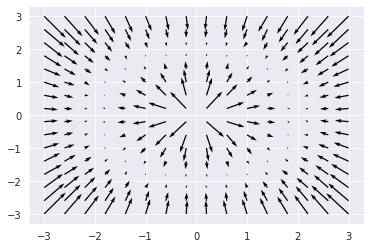

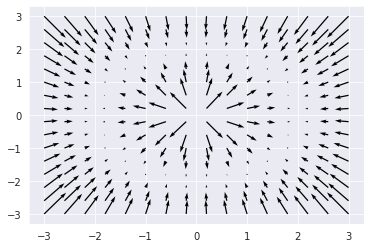

In [78]:
def plot_score(score, t, area_min=-1, area_max=1):
    if N != 2:
        print("WARNING: This function expects the score to be a function R² -> R²")
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

plot_score(nabla_log_hat_pt, 0.01, -3, 3)

## Implementing the reverse SDE
Now comes the most complicated part. Implement the reverse SDE. The function signature is given below. In JAX you cannot use `for`-loops, but need to replace them by other similar functions. The outer JAX-construct is already filled in and you only need to fill in the loop body. For the above forward SDE the reverse SDE is given as

$$dY_t = \frac{1}{2}\beta_{1-t} Y_t + \beta_{1-t} \nabla \log p_{1-t}(Y_t) + \sqrt{\beta_{1-t}} \mathrm{d}B_t.$$

### Intuition
We give a short intuitive explanation on why this SDE can be interpreted as running the above SDE backwards note that we are doing 2 things: Firstly, but a minus in front of the drift and dispersion of the forward SDE, to reverse the time direction. The minus in front of the $\mathrm{d}B_t$ vanishes, since the Brownian motion increments are symmetric noise, and "-$\mathrm{d}B_t$ has the same distribution as $\mathrm{d}B_t$".

The term $\sqrt{\beta_t}\mathrm{d}B_t$ in the forward SDE induces the paths to "spread out" (diffuse). The same thing happens with the reverse SDE, since it also has the $\sqrt{\beta_t} \mathrm{d}B_t$. But in the reverse direction we want $Y_t$ to start in a diffused distribution ($\mathcal{N}(0, I)$) and then concentrate towards a not-diffused distribution $p_0$. Therefore the $\beta_t \nabla \log p_t(x)$ term counteracts the diffusion, by forcing the $Y_t$ particles to high probability areas of $X_t$.

### Implementation
The reverse SDE is implemented using the Euler-Maryuama scheme. To advance the SDE by $\delta t$, we implement the following iteration,
$$Y_{t_{i+1}} = Y_{t_i} + (t_{i+1} - t_i) \left(\frac{1}{2} \beta_{1-t} Y_{t} + \beta_{1-t} \nabla \log p_{1-t}(Y_t)\right) + \sqrt{\beta_{1-t}} Z_{t_{i+1} - t_i},$$
where $Z_{t_{i+1} - t_i}$ is a random variable with distribution 
$$Z_{t_{i+1} - t_i} \sim \mathcal{N}(0, Z_{t_{i+1} - t_i} I).$$
We will always run the foward SDE until time $1$. Therefore the time interval for the backward SDE is also $[0, 1]$. We discretize this time interval into discrete times $(t_i)_{i=1}^R$, $t_0 = 0, t_R = 1$ and run the above scheme. 

In [79]:
R = 1000
train_ts = jnp.arange(1, R)/(R-1)

#we jit the function, but we have to mark some of the arguments as static,
#which means the function is recompiled every time these arguments are changed,
#since they are directly compiled into the binary code. This is necessary
#since jitted-functions cannot have functions as arguments. But it also 
#no problem since these arguments will never/rarely change in our case,
#therefore not triggering re-compilation.
@partial(jit, static_argnums=[1,2,3,4,5])
def reverse_sde(rng, N, n_samples, forward_drift, dispersion, score, ts=train_ts):
    """
    rng: random number generator (JAX rng)
    D: dimension in which the reverse SDE runs
    N_initial: How many samples from the initial distribution N(0, I), number
    forward_drift: drift function of the forward SDE (we implemented it above)
    disperion: dispersion function of the forward SDE (we implemented it above)
    score: The score function to use as additional drift in the reverse SDE
    ts: a discretization {t_i} of [0, T], shape 1d-array
    """
    def f(carry, params):
        t, dt = params
        x, rng = carry
        
        raise NotImplementedError
        return (x_new, rng), ()
    
    rng, step_rng = random.split(rng)
    initial = random.normal(step_rng, (n_samples, N))
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = scan(f, (initial, rng), params)
    return x

## _Helper function:_ Plot marginals
The following function helps you to plot the marginals at time.

In [88]:
def plot_heatmap(positions, area_min=-2, area_max=2):
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap=cm, interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()

With that helper function at hand we can run the above code and check if the output looks right

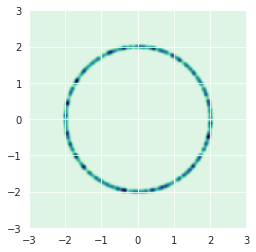

In [89]:
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, N, 5000, drift, dispersion, nabla_log_hat_pt)
plot_heatmap(samples[:, [0,1]], -3, 3)

## Bounded perturbation of the score
We will now add a bounded perturbation of the score and see that the support does not change

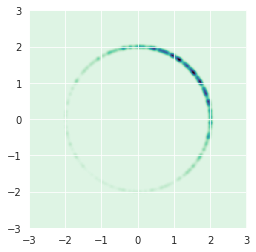

In [90]:
perturbed_score = lambda x, t: nabla_log_hat_pt(x, t) + 1
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, N, 5000, drift, dispersion, perturbed_score)
plot_heatmap(samples[:, [0,1]], -3, 3)

## Neural Network Training
Up to now we used the exact drifts $\nabla \log \hat{p}_t$ in our algorithm. These are the exact marginals of $X_t$ if $X_0$ is started in $p_0 = \hat{\mu}_\text{data} = \frac{1}{J} \sum_{j=1}^J \delta_{x_i}$. 
We again denote the distribution of $X_t$ by $p_t$ if $X_0$ is started in $p_0 = \mu_\text{data}$. Note that these are inaccessible, since we do not actually know $\mu_\text{data}$. 

Instead of using the exact drifts, we will now train a Neural Network to approximate $\nabla \log \hat{p}_t$. We do this by so-called Score-Matching Techniques. The optimal loss we would like to minimize is

$$L(\theta, t) = \mathbb{E}_{x \sim p_t(x)}[\| \nabla \log p_t(x) - s_\theta(x, t)\|^2] = \mathbb{E}_{x_0 \sim \mu_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log p_t(x) - s_\theta(x, t)\|^2]$$
which we cannot do since we do not know $\mu_\text{data}$ / cannot generate arbitrary new samples from it (if we could, we could just use these samples and would not need a SGM).

Instead, we use the following replacement loss:
$$\hat{L}(\theta, t) = \mathbb{E}_{x \sim \hat{p}_t(x)}[\| \nabla \log p_t(x) - s_\theta(x, t)\|^2] = \mathbb{E}_{x_0 \sim \hat{\mu}_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log p_t(x) - s_\theta(x, t)\|^2],$$
which can be explicitly evaluated and hope that the trained network is able to generalize. The evaluation of $\nabla \log \hat{p}_t$ is still very costly (it contains all the training examples). It can be shown that this objective, called __explicit score matching object__ is equivalent to the following __denoising score matching objective__ (see [2], Section 4.2),
$$\bar{L}(\theta, t) = \mathbb{E}_{x_0 \sim \hat{\mu}_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log p_{t,0}(x_t | x_0) - s_\theta(x, t)\|^2],$$
Since $p_{t,0}$ is Gaussian we can fully evaluate the above gradient as
$$\nabla \log p_{t, 0}(x | x_0) = \nabla \log\left( (2\pi v_t)^{-d/2}\exp(-\frac{\|x - m_t x_0\|^2}{2 v_t})\right) = -\frac{(x - m_t x_0)}{2 v_t}.$$

Finally, we want to optimize the network for all $t$, not just one specific $t$, and therefore define
$$\bar{L}(\theta) = \mathbb{E}_{t \sim U[0, 1]}[\bar{L}(\theta, t)].$$
This loss can now be approximated by randomly choosing datapoints from the training batch (as samples from $\hat{\mu}_\text{data}$ and also randomly generating times $t \sim U[0, 1]$.)
We will now first define a neural network using Flax (https://github.com/google/flax), and then train it using the above loss.

[2] A Connection Between Score Matching and Denoising Autoencoders, Pascal Vincent, https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf

In [87]:
import flax.linen as nn

class ApproximateScore(nn.Module):
    """A simple model with multiple fully connected layers and some fourier features for the time variable."""

    @nn.compact
    def __call__(self, x, t):
        in_size = x.shape[1]
        n_hidden = 256
        act = nn.relu
        t = jnp.concatenate([t - 0.5, jnp.cos(2*jnp.pi*t)],axis=1)
        x = jnp.concatenate([x, t],axis=1)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(in_size)(x)
        return x

## Hyperparameters for training and model initialization
Hyperparameters for training and model initialization. Running this cell will override the learned weights in case the model is already trained.

In [41]:
import optax

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros(N*batch_size).reshape((batch_size, N))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore()
params = score_model.init(rng, x, time)

#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

## Loss function and Update Step
Define a loss function and an update step. The update step basically takes the gradient of the loss function and then applies a gradient descent (or rather ADAM) step, to update the current weights with the attained gradient.
The full update_step function can be jitted (compiled), making the whole process very fast.

In [42]:
def loss_fn(params, model, rng, batch):
    """
    params: the current weights of the model
    model: the score function
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    
    returns an random (MC) approximation to the loss \bar{L} explained above
    """
    raise NotImplementedError
        
@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model):
    """
    params: the current weights of the model
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    opt_state: the internal state of the optimizer
    model: the score function

    takes the gradient of the loss function and updates the model weights (params) using it. Returns
    the value of the loss function (for metrics), the new params and the new optimizer state
    """
    raise NotImplementedError

## NN Training
We now train the neural network. This cell can be rerun to train the network further.

In [61]:
N_epochs = 100
train_size = mf.shape[0]
batch_size = 50
steps_per_epoch = train_size // batch_size
for k in range(N_epochs):
    rng, step_rng = random.split(rng)
    perms = jax.random.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    losses = []
    for perm in perms:
        batch = mf[perm, :]
        rng, step_rng = random.split(rng)
        loss, params, opt_state = update_step(params, step_rng, batch, opt_state, score_model)
        losses.append(loss)
    mean_loss = jnp.mean(jnp.array(losses))
    if k % 10 == 0:
        print("Epoch %d \t, Loss %f " % (k, mean_loss))

Epoch 0 	, Loss 0.315408 
Epoch 10 	, Loss 0.306614 
Epoch 20 	, Loss 0.298267 
Epoch 30 	, Loss 0.289956 
Epoch 40 	, Loss 0.304267 
Epoch 50 	, Loss 0.283583 
Epoch 60 	, Loss 0.276367 
Epoch 70 	, Loss 0.286307 
Epoch 80 	, Loss 0.299006 
Epoch 90 	, Loss 0.333567 


## Plotting the results
We now generate samples by plugging in the trained drift into our `reverse_sde` function that we have already implemented earlier.

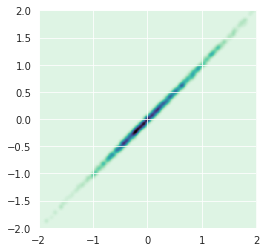

In [62]:
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, N, 1000, drift, dispersion, trained_score)
plot_heatmap(samples)